In [62]:
import numpy as np
import pandas as pd
import random
import math
from copy import deepcopy

# === Insert your actual data here ===
# Make sure the lists are in the same order of customers (1 to 24)

customer_ids = list(range(1, 25))

# Replace these sample lists with your actual data
x_coords = [147,43,112,87,89,63,209,162,209,173,261,249,192,187,269,138,227,219,68,94,107,48,145,43]
y_coords = [142,158,181,164,242,217,258,226,211,182,247,174,187,213,142,108,70,112,83,124,60,99,74,129]
demands = [48,143,149,77,216,279,163,132,231,267,91,308,264,315,191,102,328,283,69,329,301,337,291,122]

# Acceptable time window (start, end)
time_window_acceptable_start = [300,540,980,640,900,700,292,1064,708,901,474,1080,641,763,1103,377,1109,998,1146,1024,437,589,828,383]
time_window_acceptable_end = [420,660,1100,760,1020,820,412,1184,828,1021,594,1200,761,883,1223,497,1229,1118,1266,1144,557,709,948,503]

# Required time window (start, end)
time_window_required_start = [340,580,1020,300,940,740,332,1104,748,941,514,1120,681,803,1143,417,1149,1038,1186,1064,477,629,868,423]
time_window_required_end = [380,620,1060,340,980,780,372,1144,788,981,554,1160,721,843,1183,457,1189,1078,1226,1104,517,669,908,463]

# Build customers dataframe
customers = pd.DataFrame({
    'id': customer_ids,
    'x': x_coords,
    'y': y_coords,
    'demand': demands,
    'time_acc_start': time_window_acceptable_start,
    'time_acc_end': time_window_acceptable_end,
    'time_req_start': time_window_required_start,
    'time_req_end': time_window_required_end
})

# Depot location (adjust if different)
depot = {'id': 0, 'x': 80, 'y': 90}

In [63]:
# --- Parameters ---
num_vehicles = 5
vehicle_capacity = 1100
vehicle_transport_cost_per_km = 2.5
vehicle_fixed_cost = 100
max_penalty_per_vehicle = 50
max_transport_cost_per_vehicle = 1000
max_total_transport_cost = 5400      # CNY

PARTICLE_SIZE = 40  # population size
MAX_ITER = 200      # iterations

In [64]:
# --- Distance Matrix ---
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

points = [(depot['x'], depot['y'])] + list(zip(customers['x'], customers['y']))
n_points = len(points)

distance_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        distance_matrix[i][j] = euclidean_distance(points[i][0], points[i][1], points[j][0], points[j][1])

In [65]:
# --- Particle Representation ---
# Particle = permutation of customer indices (1-based: customers 1..24)
# Split into 5 routes by position-based splitting (will be adjusted)

# --- Helper functions ---

def split_routes(sequence, n_vehicles):
    """Split the sequence of customers into n_vehicles routes as evenly as possible."""
    avg_len = len(sequence) / n_vehicles
    routes = []
    last = 0.0
    while last < len(sequence):
        routes.append(sequence[int(last):int(last + avg_len)])
        last += avg_len
    return routes

In [66]:
avg_speed_kmph = 40  # average speed km/h
penalty_rate = 50    # penalty per minute late (can be used as weight)
transport_weight = 1
penalty_weight = 5
cost_per_km = 0.5    # transport cost per km
vehicle_fixed_cost = 100  # example fixed cost per vehicle
depot_index = 0      # depot index in distance matrix

def calculate_route_cost(route):
    dist = 0
    load = 0
    penalty = 0
    prev = depot_index
    arrival_time = 300  # start time in minutes (e.g., 5:00 AM)

    for cust in route:
        idx = cust  # assuming cust ID maps to distance matrix index directly

        travel_distance = distance_matrix[prev][idx]
        travel_time = (travel_distance / avg_speed_kmph) * 60  # convert to minutes
        arrival_time += travel_time

        load += customers.loc[customers['id'] == cust, 'demand'].values[0]

        time_end = customers.loc[customers['id'] == cust, 'time_req_end'].values[0]
        if arrival_time > time_end:
            penalty += (arrival_time - time_end) * penalty_rate  # penalty weighted by rate

        dist += travel_distance
        prev = idx

    dist += distance_matrix[prev][depot_index]  # return to depot

    transport_cost = dist * cost_per_km * transport_weight + vehicle_fixed_cost

    total_cost = transport_cost + penalty * penalty_weight

    return dist, load, penalty, transport_cost, total_cost

In [67]:
def fitness(particle):
    total_cost = 0
    penalty_violation = 0
    transport_violation = 0
    total_transport_cost = 0

    for route in particle:
        dist, load, penalty, transport_cost = calculate_route_cost(route)

        if penalty > max_penalty_per_vehicle:
            penalty_violation += (penalty - max_penalty_per_vehicle) * 1000

        if transport_cost > max_transport_cost_per_vehicle:
            transport_violation += (transport_cost - max_transport_cost_per_vehicle) * 1000

        total_transport_cost += transport_cost
        total_cost += transport_cost + penalty

    if total_transport_cost > max_total_transport_cost:
        transport_violation += (total_transport_cost - max_total_transport_cost) * 1000

    fitness_val = total_cost + penalty_violation + transport_violation
    return fitness_val

In [68]:
# --- PSO components ---

class Particle:
    def __init__(self, customers_list):
        if random.random() < 0.3:  # 30% chance to use heuristic initialization
            self.position = self.nearest_neighbor_init(customers_list)
        else:
            self.position = customers_list[:]
            random.shuffle(self.position)
        self.best_position = self.position[:]
        self.best_fitness = float('inf')
        self.velocity = []

    def nearest_neighbor_init(self, customers_list):
        """Initialize a route using nearest neighbor heuristic."""
        unvisited = customers_list.copy()
        route = []
        current = 0  # Depot
        while unvisited:
            nearest = min(unvisited, key=lambda x: distance_matrix[current][x])
            route.append(nearest)
            unvisited.remove(nearest)
            current = nearest
        return route

    def update_velocity(self, global_best, w=0.5, c1=1.0, c2=1.0):
        # Velocity here as swap operations between positions

        def get_swaps(a, b):
            """Find swaps to convert permutation a to b."""
            swaps = []
            a = a[:]
            for i in range(len(a)):
                if a[i] != b[i]:
                    swap_idx = a.index(b[i])
                    swaps.append((i, swap_idx))
                    a[i], a[swap_idx] = a[swap_idx], a[i]
            return swaps

        swaps_to_pbest = get_swaps(self.position, self.best_position)
        swaps_to_gbest = get_swaps(self.position, global_best)

        # Combine swaps with coefficients and inertia
        new_velocity = []

        # Inertia: keep some old velocity
        for v in self.velocity:
            if random.random() < w:
                new_velocity.append(v)

        # Add some swaps towards personal best
        for v in swaps_to_pbest:
            if random.random() < c1 / len(swaps_to_pbest):
                new_velocity.append(v)

        # Add some swaps towards global best
        for v in swaps_to_gbest:
            if random.random() < c2 / len(swaps_to_gbest):
                new_velocity.append(v)

        # Keep velocity reasonable size
        if len(new_velocity) > 30:
            new_velocity = random.sample(new_velocity, 30)

        self.velocity = new_velocity

    def apply_velocity(self):
        pos = self.position[:]
        for (i, j) in self.velocity:
            pos[i], pos[j] = pos[j], pos[i]
        self.position = pos

In [69]:
# --- PSO main loop ---

def evaluate_solution(solution, vehicle_capacity, distance_matrix, customers, avg_speed_kmph, delivery_start_min=300):
    total_fixed_cost = 100 * len(solution)
    total_transport_cost = 0
    total_penalty_cost = 0
    vehicle_results = []

    for route in solution:
        if not route:
            continue
        load = 0
        dist = 0
        penalty = 0
        transport_cost = 0
        arrival_time = delivery_start_min
        prev_node = 0  # depot is 0 index

        for cust_id in route:
            cust_idx = cust_id  # adjust for 1-based IDs
            demand = customers.loc[customers['id'] == cust_id, 'demand'].values[0]
            # Access the required time window columns directly
            time_req_start = customers.loc[customers['id'] == cust_id, 'time_req_start'].values[0]
            time_req_end = customers.loc[customers['id'] == cust_id, 'time_req_end'].values[0]

            # travel time
            travel_time = (distance_matrix[prev_node][cust_idx] / avg_speed_kmph)
            arrival_time += travel_time

            # Penalty: only if arrival_time > latest time in window (using required end time)
            if arrival_time > time_req_end:
                penalty += (arrival_time - time_req_end) * penalty_rate  # penalty rate

            load += demand
            dist += distance_matrix[prev_node][cust_idx]
            prev_node = cust_idx

        # Return to depot
        dist += distance_matrix[prev_node][0]
        transport_cost = dist * cost_per_km  # cost per unit distance

        total_transport_cost += transport_cost
        total_penalty_cost += penalty

        vehicle_results.append({
            "route": route,
            "load": load,
            "distance": dist,
            "transport_cost": transport_cost,
            "penalty_cost": penalty
        })

    total_cost = total_fixed_cost + total_transport_cost + total_penalty_cost
    return total_cost, vehicle_results

def decode_routes(position, vehicle_capacity, customers_df):
    routes = []
    current_route = []
    current_load = 0

    for cust_id in position:
        demand = customers_df.loc[customers_df['id'] == cust_id, 'demand'].values[0]
        if current_load + demand <= vehicle_capacity:
            current_route.append(cust_id)
            current_load += demand
        else:
            routes.append(current_route)
            current_route = [cust_id]
            current_load = demand

    if current_route:
        routes.append(current_route)

    return routes

def PSO():
    # Initialize particles
    particles = [Particle(customer_ids) for _ in range(PARTICLE_SIZE)]

    global_best_position = None
    global_best_fitness = float('inf')
    global_best_data = None  # save additional info

    for iteration in range(MAX_ITER):
        for particle in particles:
            decoded_routes = decode_routes(particle.position, vehicle_capacity, customers)
            # The evaluate_solution function now correctly accesses time window data
            fitness, vehicle_data = evaluate_solution(decoded_routes, vehicle_capacity, distance_matrix, customers, avg_speed_kmph)

            if fitness < particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position[:]

            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle.position[:]
                # Need to extract lists from vehicle_data for global_best_data
                loads = [v['load'] for v in vehicle_data]
                dists = [v['distance'] for v in vehicle_data]
                trans_costs = [v['transport_cost'] for v in vehicle_data]
                penalties = [v['penalty_cost'] for v in vehicle_data]
                routes = [v['route'] for v in vehicle_data]
                global_best_data = (loads, dists, trans_costs, penalties, routes)

        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.apply_velocity()

        if iteration % 10 == 0 or iteration == MAX_ITER - 1:
            print(f"Iteration {iteration + 1}/{MAX_ITER} - Best Cost: {global_best_fitness:.2f}")

    return global_best_fitness, global_best_position, global_best_data

In [70]:
!pip install matplotlib


In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd # Ensure pandas is imported

def plot_vehicle_routes_with_loads(routes, customers_df, vehicle_loads, depot_info):
    plt.figure(figsize=(12, 8))

    # Define color map
    colors = plt.cm.get_cmap('tab10', len(routes))

    # Combine depot and customers data for easy lookup
    # Create a temporary DataFrame for lookup including the depot
    depot_df_temp = pd.DataFrame([depot_info])
    all_locations = pd.concat([depot_df_temp, customers_df], ignore_index=True)
    all_locations = all_locations.set_index('id') # Set id as index for faster lookup

    # Plot all customers
    # Exclude depot from the customer plotting loop
    for cust_id, row in customers_df.iterrows(): # Iterate over customers_df rows
        plt.plot(row['x'], row['y'], 'ko')
        plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['id']), fontsize=9)


    # Plot depot using depot_info dictionary
    depot_id = depot_info['id']
    depot_x = depot_info['x']
    depot_y = depot_info['y']
    plt.plot(depot_x, depot_y, 'rs', markersize=10)
    plt.text(depot_x + 0.5, depot_y + 0.5, 'Depot', fontsize=10, fontweight='bold')

    # For legend
    legend_patches = []

    # Plot vehicle routes
    for i, route in enumerate(routes):
        color = colors(i)
        prev_id = depot_id

        for cust_id in route:
            # Use all_locations (including depot) for coordinate lookup by id
            x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
            x2, y2 = all_locations.loc[cust_id, ['x', 'y']].values
            plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                      head_width=1.2, alpha=0.8)
            prev_id = cust_id

        # Return to depot
        x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
        x2, y2 = depot_x, depot_y # Use depot_x, depot_y directly
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                  head_width=1.2, linestyle='--', alpha=0.5)

        # Add legend entry
        legend_patches.append(mpatches.Patch(color=color, label=f'Vehicle {i + 1} - Load: {vehicle_loads[i]}'))

    plt.title('Vehicle Routes with Loads')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.legend(handles=legend_patches, loc='upper right')
    plt.show()


In [72]:
# --- Run PSO ---
best_cost, best_pos, best_data = PSO()

loads, dists, trans_costs, penalties, best_routes = best_data

# --- Print Results ---
print("\n===== Optimized Solution =====")
total_transport_cost = sum(trans_costs)
total_penalty_cost = sum(penalties)
total_fixed = vehicle_fixed_cost * num_vehicles
print(f"Total Fixed Cost (all vehicles): {total_fixed}")
print(f"Total Transport Cost (all vehicles): {total_transport_cost:.2f}")
print(f"Total Penalty Cost (all vehicles): {total_penalty_cost:.2f}")
print(f"Total Cost: {best_cost:.2f}")

for i, route in enumerate(best_routes):
    print(f"\nVehicle {i+1}:")
    print(f"  Route: Depot -> " + " -> ".join(str(c) for c in route) + " -> Depot")
    print(f"  Load: {loads[i]} kg")
    print(f"  Distance: {dists[i]:.2f} units")
    print(f"  Transport Cost: {trans_costs[i]:.2f} CNY")
    print(f"  Penalty Cost: {penalties[i]:.2f} CNY")

Iteration 1/200 - Best Cost: 1519.64
Iteration 11/200 - Best Cost: 1519.64
Iteration 21/200 - Best Cost: 1519.64
Iteration 31/200 - Best Cost: 1514.19
Iteration 41/200 - Best Cost: 1514.19
Iteration 51/200 - Best Cost: 1513.94
Iteration 61/200 - Best Cost: 1513.94
Iteration 71/200 - Best Cost: 1513.94
Iteration 81/200 - Best Cost: 1503.80
Iteration 91/200 - Best Cost: 1503.80
Iteration 101/200 - Best Cost: 1503.80
Iteration 111/200 - Best Cost: 1503.80
Iteration 121/200 - Best Cost: 1495.01
Iteration 131/200 - Best Cost: 1495.01
Iteration 141/200 - Best Cost: 1495.01
Iteration 151/200 - Best Cost: 1495.01
Iteration 161/200 - Best Cost: 1495.01
Iteration 171/200 - Best Cost: 1495.01
Iteration 181/200 - Best Cost: 1495.01
Iteration 191/200 - Best Cost: 1495.01
Iteration 200/200 - Best Cost: 1495.01

===== Optimized Solution =====
Total Fixed Cost (all vehicles): 500
Total Transport Cost (all vehicles): 995.01
Total Penalty Cost (all vehicles): 0.00
Total Cost: 1495.01

Vehicle 1:
  Route

<ipython-input-71-5925af9311bc>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes))


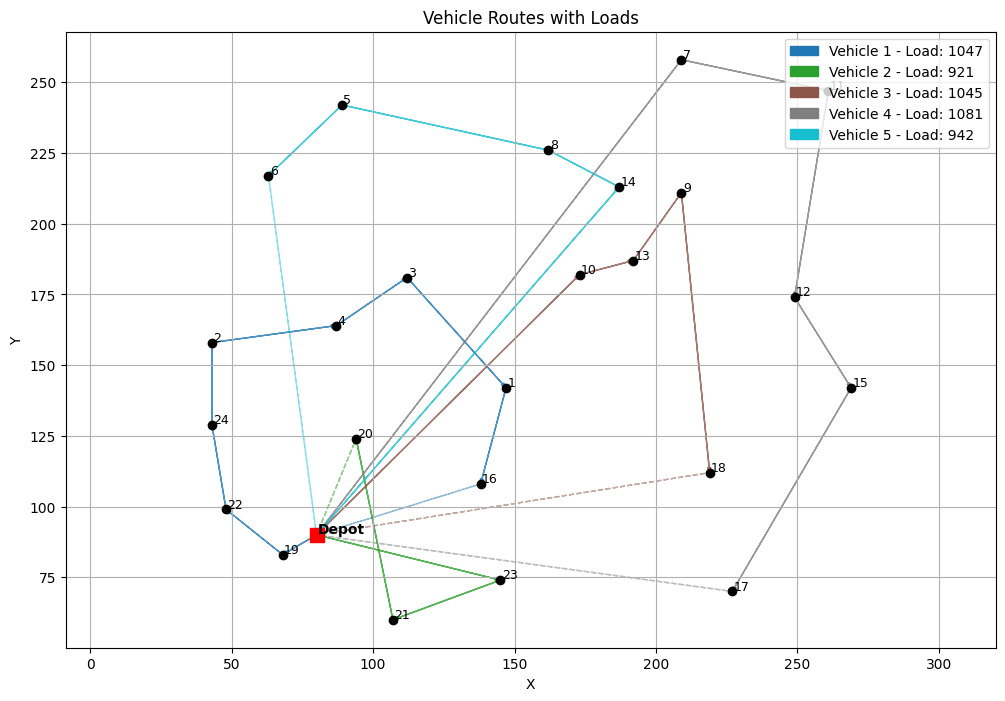

In [73]:
plot_vehicle_routes_with_loads(best_routes, customers_df=customers, vehicle_loads=loads, depot_info= depot)